### **Twitter Bot Detection Model**

**Contributed by:**
**1. Divyanshi Bhojak**
**2. Tarushi Jat**

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Necessary Import**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['patch.force_edgecolor'] = True
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier, VotingClassifier 
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB   
from sklearn.metrics import confusion_matrix,  classification_report, roc_auc_score

In [ ]:
def display_cm(y_test, model_pred):
  CM = confusion_matrix(y_test, model_pred)
  f, ax = plt.subplots(figsize=(8,8))
  sns.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.Blues)
  plt.xlabel("Prediction(Ypred)")
  plt.ylabel("Ytrue")
  plt.show()

In [ ]:
def display(y_test, model_pred):
  #print("-----------------------------------------------------------")
  print("Accuracy Score :-", accuracy_score(y_test, model_pred))
  #print("-----------------------------------------------------------")
  print("roc_auc Score :-", roc_auc_score(y_test, model_pred))
  #print("-----------------------------------------------------------")
  print("Classification Report:-")
  print()
  print(classification_report(y_test, model_pred))

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/Projects/datasets_full.csv/dataset/training_data_2_csv_UTF.csv")
spam_bot = train_data[train_data.bot==1]
legitimate = train_data[train_data.bot==0]

### **Exploratory Data Analysis**

In [ ]:
train_data.head(5)

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listed_count,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,8.160000e+17,"""815745789754417152""","""HoustonPokeMap""","""Houston, TX""","""Rare and strong PokŽmon in Houston, TX. See m...","""https://t.co/dnWuDbFRkt""",1291,0,10,"""Mon Jan 02 02:25:26 +0000 2017""",0,False,78554,"""en""","{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",True,False,False,"""Houston PokŽ Alert""",1
1,4.843621e+09,4843621225,kernyeahx,"Templeville town, MD, USA",From late 2014 Socium Marketplace will make sh...,NaN,1,349,0,2/1/2016 7:37,38,False,31,en,NaN,True,False,False,Keri Nelson,1
2,4.303727e+09,4303727112,mattlieberisbot,NaN,"Inspired by the smart, funny folks at @replyal...",https://t.co/P1e1o0m4KC,1086,0,14,Fri Nov 20 18:53:22 +0000 2015,0,False,713,en,"{'retweeted': False, 'is_quote_status': False,...",True,False,False,Matt Lieber Is Bot,1
3,3.063139e+09,3063139353,sc_papers,NaN,NaN,NaN,33,0,8,2/25/2015 20:11,0,False,676,en,Construction of human anti-tetanus single-chai...,True,True,False,single cell papers,1
4,2.955142e+09,2955142070,lucarivera16,"Dublin, United States",Inspiring cooks everywhere since 1956.,NaN,11,745,0,1/1/2015 17:44,146,False,185,en,NaN,False,False,False,lucarivera16,1


In [ ]:
results = dict()

In [ ]:
spam_bot['bot'] = 1
legitimate['bot'] = 0
data = pd.concat([spam_bot, legitimate])

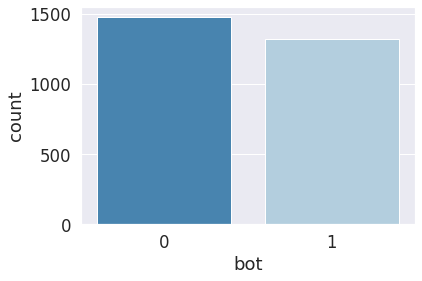

In [ ]:

sns.set_style("darkgrid")
sns.countplot(data['bot'], palette="Blues_r")

In [ ]:
len(spam_bot)

1321

In [ ]:
len(legitimate)

1476

In [ ]:
spam_bot.head()

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listed_count,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
0,8.160000e+17,"""815745789754417152""","""HoustonPokeMap""","""Houston, TX""","""Rare and strong PokŽmon in Houston, TX. See m...","""https://t.co/dnWuDbFRkt""",1291,0,10,"""Mon Jan 02 02:25:26 +0000 2017""",0,False,78554,"""en""","{\r ""created_at"": ""Sun Mar 12 15:44:04 +0...",True,False,False,"""Houston PokŽ Alert""",1
1,4.843621e+09,4843621225,kernyeahx,"Templeville town, MD, USA",From late 2014 Socium Marketplace will make sh...,NaN,1,349,0,2/1/2016 7:37,38,False,31,en,NaN,True,False,False,Keri Nelson,1
2,4.303727e+09,4303727112,mattlieberisbot,NaN,"Inspired by the smart, funny folks at @replyal...",https://t.co/P1e1o0m4KC,1086,0,14,Fri Nov 20 18:53:22 +0000 2015,0,False,713,en,"{'retweeted': False, 'is_quote_status': False,...",True,False,False,Matt Lieber Is Bot,1
3,3.063139e+09,3063139353,sc_papers,NaN,NaN,NaN,33,0,8,2/25/2015 20:11,0,False,676,en,Construction of human anti-tetanus single-chai...,True,True,False,single cell papers,1
4,2.955142e+09,2955142070,lucarivera16,"Dublin, United States",Inspiring cooks everywhere since 1956.,NaN,11,745,0,1/1/2015 17:44,146,False,185,en,NaN,False,False,False,lucarivera16,1


In [ ]:
legitimate.head()

,id,id_str,screen_name,location,description,url,followers_count,friends_count,listed_count,created_at,favourites_count,verified,statuses_count,lang,status,default_profile,default_profile_image,has_extended_profile,name,bot
1321,34716038.0,34716038,aaroncarter,Sony Recording Artist,NEW AARON CARTER MUSIC DOWNLOAD LINK LÌüVÌÇ EP...,NaN,571310,76070,4909,Thu Apr 23 20:15:49 +0000 2009,37437,True,56077,en,"{u'contributors': None, u'truncated': False, u...",False,False,True,Aaron Carter,0
1322,3013511.0,3013511,michellebranch,NaN,"singer/songwriter, hopeless romantic, drinker ...",https://t.co/2vSKw7cmzC,292385,963,6076,Fri Mar 30 20:58:59 +0000 2007,1248,True,16688,en,"{u'contributors': None, u'truncated': False, u...",False,False,False,Michelle Branch,0
1323,56237623.0,56237623,stronginmyfaith,NaN,NaN,NaN,1,7,0,7/13/2009 0:38,0,False,3,en,"Status(contributors=None, truncated=False, tex...",True,True,False,laurie lindeman,0
1324,27964284.0,27964284,Jessicaveronica,5th Dimension,"@TheVeronicas ‰Ü Wanderer, worshiper, if you ...",https://t.co/U6yNZoDZfu,222659,352,3261,Tue Mar 31 21:12:33 +0000 2009,143,True,10999,en,"{u'contributors': None, u'truncated': False, u...",False,False,False,Jessica Veronica,0
1325,552876065.0,552876065,resargento,brasil,meio ogra mas o coraí_í£o í© de mocinha,NaN,646,446,2,4/13/2012 17:37,13440,False,25292,pt,NaN,False,False,False,rebosta,0


In [ ]:
#spam_bot_bot[spam_bot.listedcount>10000]
condition = (spam_bot.screen_name.str.contains("bot", case=False)==True)|(spam_bot.description.str.contains("bot", case=False)==True)|(spam_bot.location.isnull())|(spam_bot.verified==False)

spam_bot['screen_name_binary'] = (spam_bot.screen_name.str.contains("bot", case=False)==True)
spam_bot['location_binary'] = (spam_bot.location.isnull())
spam_bot['verified_binary'] = (spam_bot.verified==False)
spam_bot.shape

(1321, 23)

In [ ]:
condition = (legitimate.screen_name.str.contains("bot", case=False)==False)| (legitimate.description.str.contains("bot", case=False)==False) |(legitimate.location.isnull()==False)|(legitimate.verified==True)

legitimate['screen_name_binary'] = (legitimate.screen_name.str.contains("bot", case=False)==False)
legitimate['location_binary'] = (legitimate.location.isnull()==False)
legitimate['verified_binary'] = (legitimate.verified==True)

legitimate.shape

(1476, 23)

In [ ]:
df = pd.concat([spam_bot, legitimate])
df.shape

(2797, 23)

### Feature Independence using Spearman correlation

In [ ]:
df.corr(method='spearman')

,id,followers_count,friends_count,listed_count,favourites_count,verified,statuses_count,default_profile,default_profile_image,bot,screen_name_binary,location_binary,verified_binary
id,1.000000,-0.672925,-0.402346,-0.615005,-0.439430,-0.611899,-0.451945,0.522990,0.166601,0.652131,-0.576100,-0.228328,0.150100
followers_count,-0.672925,1.000000,0.375522,0.896126,0.457363,0.709732,0.649117,-0.496899,-0.293838,-0.468430,0.458213,0.189675,0.130717
friends_count,-0.402346,0.375522,1.000000,0.204403,0.641529,0.356452,0.111118,-0.296358,-0.097607,-0.483105,0.342145,0.082692,-0.210592
listed_count,-0.615005,0.896126,0.204403,1.000000,0.349059,0.694340,0.684976,-0.447376,-0.269035,-0.318445,0.338698,0.188797,0.281360
favourites_count,-0.439430,0.457363,0.641529,0.349059,1.000000,0.394227,0.295108,-0.348043,-0.226956,-0.526228,0.408864,0.120941,-0.220894
verified,-0.611899,0.709732,0.356452,0.694340,0.394227,1.000000,0.333278,-0.404650,-0.132298,-0.508555,0.434177,0.191922,0.346505
statuses_count,-0.451945,0.649117,0.111118,0.684976,0.295108,0.333278,1.000000,-0.375918,-0.289999,-0.089018,0.162213,0.105333,0.207384
default_profile,0.522990,-0.496899,-0.296358,-0.447376,-0.348043,-0.404650,-0.375918,1.000000,0.246979,0.407748,-0.377572,-0.138378,0.072351
default_profile_image,0.166601,-0.293838,-0.097607,-0.269035,-0.226956,-0.132298,-0.289999,0.246979,1.000000,0.139669,-0.166388,0.000596,0.033021
bot,0.652131,-0.468430,-0.483105,-0.318445,-0.526228,-0.508555,-0.089018,0.407748,0.139669,1.000000,-0.843429,-0.266342,0.606771


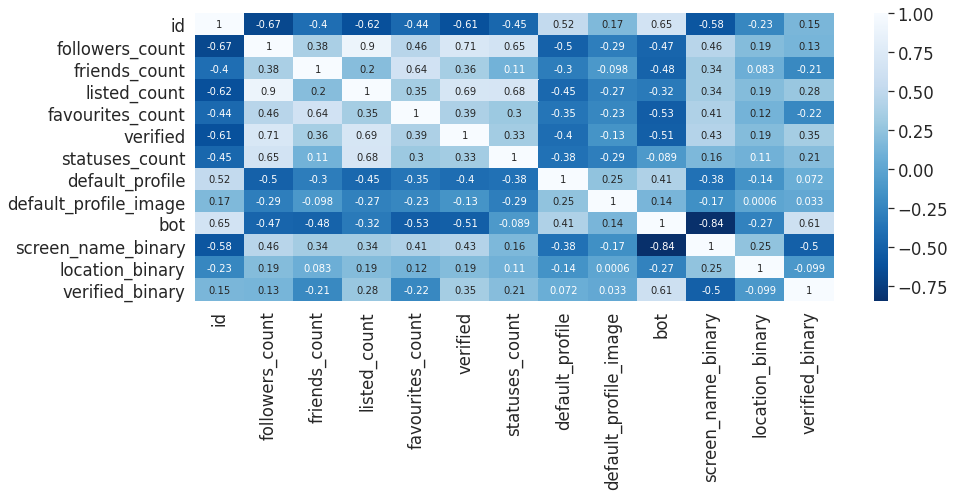

In [ ]:
plt.figure(figsize=(14,7))
sns.heatmap(df.corr(method='spearman'), cmap='Blues_r', annot=True)
plt.tight_layout()
plt.show()

Result:
- There is no correlation between **id, statuses_count, default_profile, default_profile_image** and target variable.
- There is strong correlation between **verified, listed_count, friends_count, followers_count** and target variable.
- We cannot perform correlation for categorical attributes. So we will take **screen_name, name, description, status** into feature engineering. While use **verified, listed_count** for feature extraction.

#### Performing Feature Engineering

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/WSC project/datasets_full.csv/dataset/training_data_2_csv_UTF.csv")

bag_of_words_bot = r'bot|b0t|cannabis|tweet me|mishear|follow me|updates every|gorilla|yes_ofc|forget' \
                    r'expos|kill|clit|bbb|butt|XXX|truthe|fake|anony|free|virus|funky|RNA|kuck|jargon' \
                    r'nerd|swag|jack|bang|bonsai|chick|prison|paper|pokem|xx|freak|ffd|dunia|clone|genie|bbb' \
                    r'ffd|onlyman|emoji|joke|troll|droop|free|every|wow|cheese|yeah|bio|magic|wizard|face'
            
train_data['screen_name_binary'] = train_data.screen_name.str.contains(bag_of_words_bot, case=False, na=False)
train_data['name_binary'] = train_data.name.str.contains(bag_of_words_bot, case=False, na=False)
train_data['description_binary'] = train_data.description.str.contains(bag_of_words_bot, case=False, na=False)
train_data['status_binary'] = train_data.status.str.contains(bag_of_words_bot, case=False, na=False)

In [ ]:
train_data['listed_count_binary'] = (train_data.listed_count>20000)==False
features = ['screen_name_binary', 'name_binary', 'description_binary', 'status_binary', 'verified', 'followers_count', 'friends_count', 'statuses_count', 'listed_count_binary', 'bot']

In [ ]:
X = train_data[features].iloc[:,:-1]
y = train_data[features].iloc[:,-1]

# **Model Implementation**

#### **1. Decision Tree Classifier**

In [ ]:

dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

dt = dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.88511
Test Accuracy: 0.86250


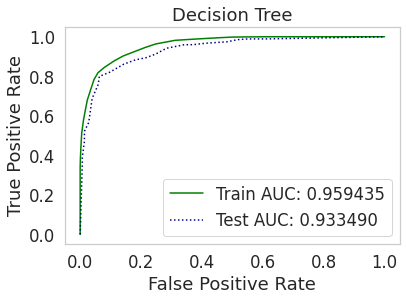

In [ ]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = dt.predict_proba(X_train)
scores_test = dt.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_dt_train, tpr_dt_train, color='green', label='Train AUC: %5f' %auc(fpr_dt_train, tpr_dt_train))
plt.plot(fpr_dt_test, tpr_dt_test, color='darkblue', ls=':', label='Test AUC: %5f' %auc(fpr_dt_test, tpr_dt_test))
plt.title("Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')

In [ ]:
pred = dt.predict(X_test)

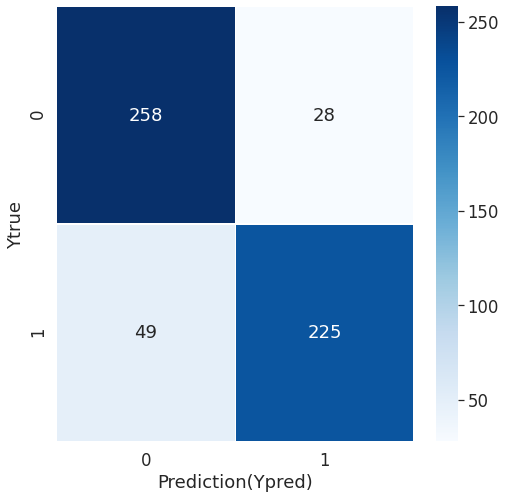

In [ ]:
display_cm(y_test, y_pred_test)

In [ ]:
display(y_test, y_pred_test)

Accuracy Score :- 0.8625
roc_auc Score :- 0.8616328926547905
Classification Report:-

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       286
           1       0.89      0.82      0.85       274

    accuracy                           0.86       560
   macro avg       0.86      0.86      0.86       560
weighted avg       0.86      0.86      0.86       560



#### **2. Multinomial Naive Bayes Classifier**




In [ ]:


mnb = MultinomialNB(alpha=0.0009)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

mnb = mnb.fit(X_train, y_train)
y_pred_train = mnb.predict(X_train)
y_pred_test = mnb.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.68440
Test Accuracy: 0.68750


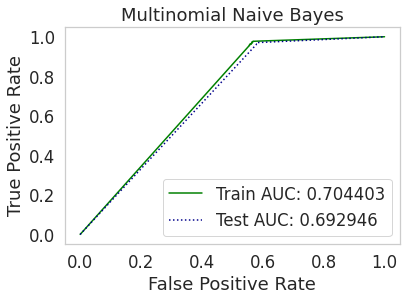

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = mnb.predict_proba(X_train)
scores_test = mnb.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_mnb_train, tpr_mnb_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_mnb_test, tpr_mnb_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_mnb_train, tpr_mnb_train, color='green', label='Train AUC: %5f' %auc(fpr_mnb_train, tpr_mnb_train))
plt.plot(fpr_mnb_test, tpr_mnb_test, color='darkblue', ls=':', label='Test AUC: %5f' %auc(fpr_mnb_test, tpr_mnb_test))
plt.title("Multinomial Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')

In [ ]:
pred = mnb.predict(X_test)

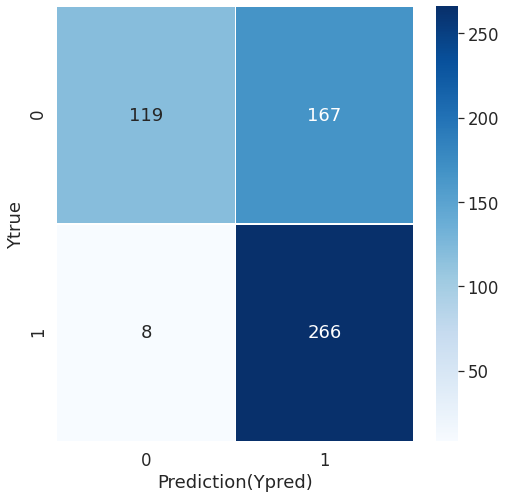

In [ ]:
display_cm(y_test, y_pred_test)

In [ ]:
display(y_test, y_pred_test)

Accuracy Score :- 0.6875
roc_auc Score :- 0.6934434178959726
Classification Report:-

              precision    recall  f1-score   support

           0       0.94      0.42      0.58       286
           1       0.61      0.97      0.75       274

    accuracy                           0.69       560
   macro avg       0.78      0.69      0.66       560
weighted avg       0.78      0.69      0.66       560



#### **3. Bernoulli Naive Bayes**

In [ ]:


bnb = BernoulliNB()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

bnb = bnb.fit(X_train, y_train)
y_pred_train = mnb.predict(X_train)
y_pred_test = mnb.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.68012
Test Accuracy: 0.69643


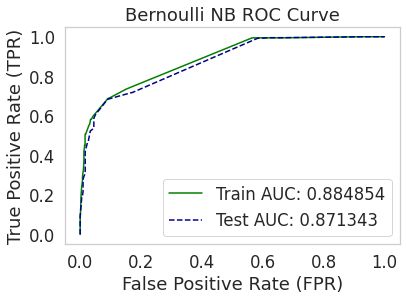

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = bnb.predict_proba(X_train)
scores_test = bnb.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_mnb_train, tpr_mnb_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_mnb_test, tpr_mnb_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_mnb_train, tpr_mnb_train, color='green', label='Train AUC: %5f' %auc(fpr_mnb_train, tpr_mnb_train))
plt.plot(fpr_mnb_test, tpr_mnb_test, color='darkblue', ls='--', label='Test AUC: %5f' %auc(fpr_mnb_test, tpr_mnb_test))
plt.title("Bernoulli NB ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

In [ ]:
pred = bnb.predict(X_test)

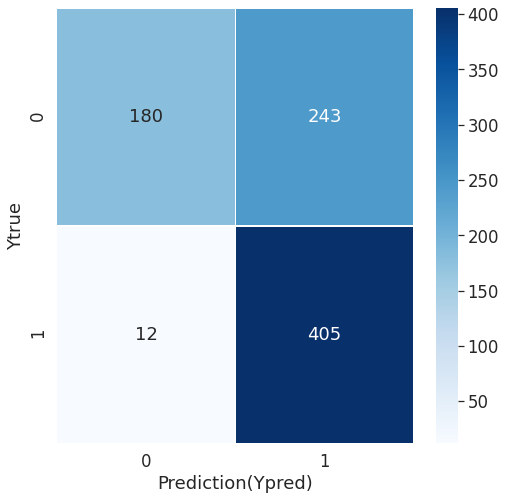

In [ ]:
display_cm(y_test, y_pred_test)

In [ ]:
display(y_test, y_pred_test)

Accuracy Score :- 0.6964285714285714
roc_auc Score :- 0.6983774682381754
Classification Report:-

              precision    recall  f1-score   support

           0       0.94      0.43      0.59       423
           1       0.62      0.97      0.76       417

    accuracy                           0.70       840
   macro avg       0.78      0.70      0.67       840
weighted avg       0.78      0.70      0.67       840



### **4. Bagging Model**

In [ ]:
bag = BaggingClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

bag = bag.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.88511
Test Accuracy: 0.86250


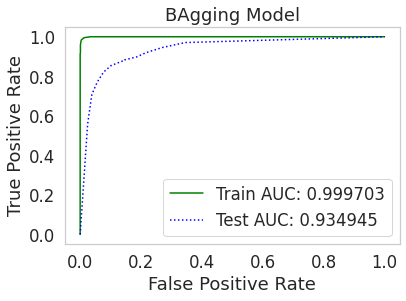

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = bag.predict_proba(X_train)
scores_test = bag.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_mnb_train, tpr_mnb_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_mnb_test, tpr_mnb_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_mnb_train, tpr_mnb_train, color='green', label='Train AUC: %5f' %auc(fpr_mnb_train, tpr_mnb_train))
plt.plot(fpr_mnb_test, tpr_mnb_test, color='blue', ls=':', label='Test AUC: %5f' %auc(fpr_mnb_test, tpr_mnb_test))
plt.title("BAgging Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')

In [ ]:
pred = bag.predict(X_test)

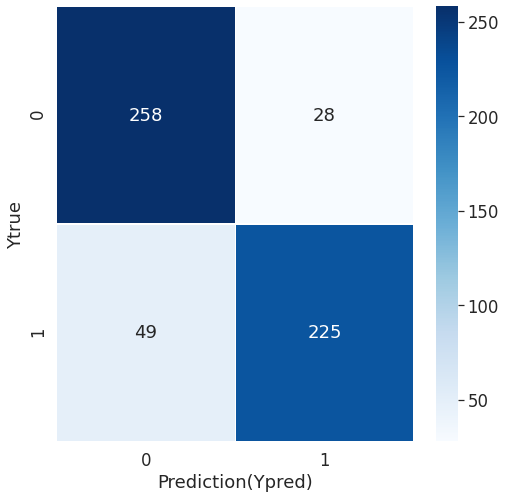

In [ ]:
display_cm(y_test, y_pred_test)

In [ ]:
display(y_test, y_pred_test)

Accuracy Score :- 0.8625
roc_auc Score :- 0.8616328926547905
Classification Report:-

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       286
           1       0.89      0.82      0.85       274

    accuracy                           0.86       560
   macro avg       0.86      0.86      0.86       560
weighted avg       0.86      0.86      0.86       560



###  **5. XG Boost Model**

In [ ]:


import xgboost
from xgboost import XGBRFClassifier

xgb = XGBRFClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

xgb = xgb.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))


Trainig Accuracy: 0.87787
Test Accuracy: 0.86310


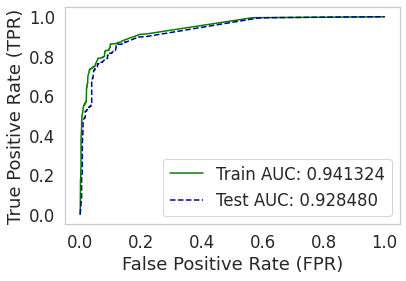

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = xgb.predict_proba(X_train)
scores_test = xgb.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_rf_train, tpr_rf_train, color='green', label='Train AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_rf_test, tpr_rf_test, color='darkblue', ls='--', label='Test AUC: %5f' %auc(fpr_rf_test, tpr_rf_test))
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

In [ ]:
pred = xgb.predict(X_test)

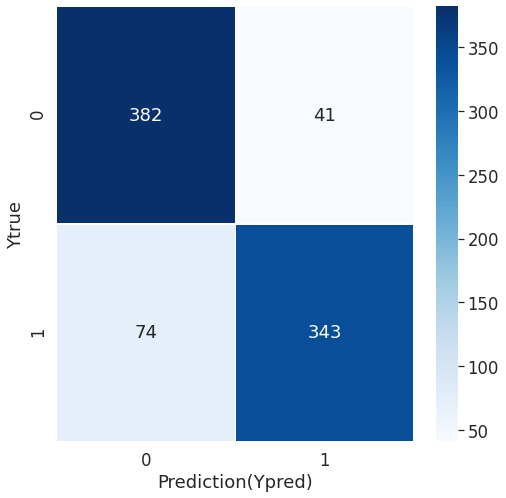

In [ ]:
display_cm(y_test, y_pred_test)

In [ ]:
display(y_test, y_pred_test)

Accuracy Score :- 0.8630952380952381
roc_auc Score :- 0.862807626239434
Classification Report:-

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       423
           1       0.89      0.82      0.86       417

    accuracy                           0.86       840
   macro avg       0.87      0.86      0.86       840
weighted avg       0.87      0.86      0.86       840



### **6. Majority Voting Classifier**

In [ ]:
voting_classifier = VotingClassifier(estimators=[('decision tree', dt), ('XG_boost', xgb), ('Bagging', bag), ('mnb', mnb), ('bnb', bnb)], voting='hard')
voting_classifier = voting_classifier.fit(X_train, y_train)
vc_pred_test = voting_classifier.predict(X_test)
vc_pred_train = voting_classifier.predict(X_train)

In [ ]:


print("Trainig Accuracy: %.5f" %accuracy_score(y_train, vc_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, vc_pred_test))

Trainig Accuracy: 0.93473
Test Accuracy: 0.88571


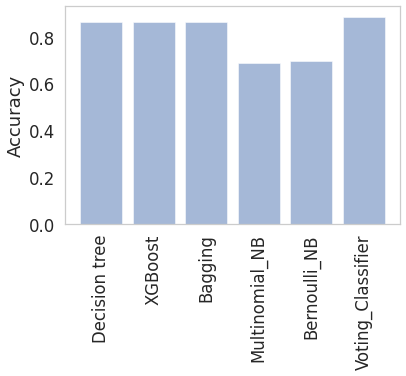

In [ ]:
models = ('Decision tree', 'XGBoost', 'Bagging', 'Multinomial_NB', 'Bernoulli_NB', 'Voting_Classifier')
y_pos = np.arange(len(models))
accuracy = [0.86250, 0.86310,  0.86071, 0.68750, 0.69643, 0.88571]

plt.xticks(y_pos, models, rotation=90)
plt.bar(y_pos, accuracy, align='center', alpha=0.5)
plt.xticks(y_pos, models)
plt.ylabel('Accuracy')

plt.show()

In [ ]:
display(y_test, vc_pred)

Accuracy Score :- 0.8761904761904762
roc_auc Score :- 0.8757759749647092
Classification Report:-

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       423
           1       0.92      0.82      0.87       417

    accuracy                           0.88       840
   macro avg       0.88      0.88      0.88       840
weighted avg       0.88      0.88      0.88       840



In [ ]:
display(y_test, vc_pred)

Accuracy Score :- 0.8916666666666667
roc_auc Score :- 0.891533581645322
Classification Report:-

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       423
           1       0.91      0.87      0.89       417

    accuracy                           0.89       840
   macro avg       0.89      0.89      0.89       840
weighted avg       0.89      0.89      0.89       840



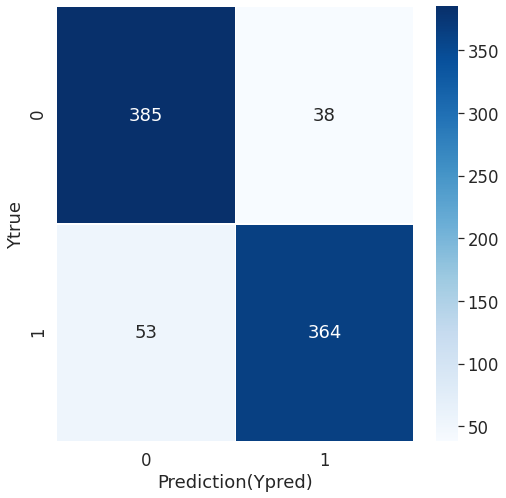

In [ ]:
display_cm(y_test, vc_pred)